# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

# 📊 Megaline Telecom Plan Revenue Analysis

## Overview

This project involves an in-depth analysis for **Megaline**, a telecom provider offering two prepaid plans: **Surf** and **Ultimate**. The goal is to identify which plan generates more revenue by analyzing customer behavior from a dataset of 500 users.

This insight helps Megaline's commercial department optimize marketing spend and adjust advertising efforts.

---

## Initialization

In [42]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


## Load data

In [43]:
# Load the data files into different DataFrames

users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')


## Prepare the data

[The data for this project is split into several tables. Explore each one to get an initial understanding of the data. Do necessary corrections to each table if necessary.]

## Plans

In [44]:
# Print the general/summary information about the plans' DataFrame
plans.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [45]:
# Print a sample of data for plans
plans.head()



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

## Fix data

[Fix obvious issues with the data given the initial observations.]

In [46]:
# Fix date formats in all relevant tables
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])

# Round call durations up to the next minute, as per billing policy
calls['duration'] = np.ceil(calls['duration']).astype(int)

# Confirm changes
print(users.dtypes)
print(calls.dtypes)
print(messages.dtypes)
print(internet.dtypes)

user_id                int64
first_name            object
last_name             object
age                    int64
city                  object
reg_date      datetime64[ns]
plan                  object
churn_date    datetime64[ns]
dtype: object
id                   object
user_id               int64
call_date    datetime64[ns]
duration              int64
dtype: object
id                      object
user_id                  int64
message_date    datetime64[ns]
dtype: object
id                      object
user_id                  int64
session_date    datetime64[ns]
mb_used                float64
dtype: object


## Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [47]:
# Add a 'month' column to each dataset for grouping
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

# Group data by user_id and month
monthly_calls = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
monthly_calls.rename(columns={'duration': 'minutes_used'}, inplace=True)

monthly_messages = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
monthly_messages.rename(columns={'id': 'messages_sent'}, inplace=True)

monthly_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
monthly_internet.rename(columns={'mb_used': 'mb_used_total'}, inplace=True)

# Convert MB to GB and round up (Megaline charges per GB, rounding total)
monthly_internet['gb_used'] = np.ceil(monthly_internet['mb_used_total'] / 1024).astype(int)

# Merge all monthly usage data into a single DataFrame
monthly_usage = monthly_calls.merge(monthly_messages, on=['user_id', 'month'], how='outer')
monthly_usage = monthly_usage.merge(monthly_internet[['user_id', 'month', 'gb_used']], on=['user_id', 'month'], how='outer')

# Fill missing values with 0 (means user had no activity in that category for that month)
monthly_usage = monthly_usage.fillna(0)

# Merge with user data to include plan information
monthly_usage = monthly_usage.merge(users[['user_id', 'plan']], on='user_id', how='left')

# Check result
monthly_usage.head()

,user_id,month,minutes_used,messages_sent,gb_used,plan
0,1000,12,124.0,11.0,2.0,ultimate
1,1001,8,182.0,30.0,7.0,surf
2,1001,9,315.0,44.0,14.0,surf
3,1001,10,393.0,53.0,22.0,surf
4,1001,11,426.0,36.0,19.0,surf


## Users

In [48]:
# Print the general/summary information about the users' DataFrame

users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [49]:
# Print a sample of data for users

users.sample(5)

# Check for missing values
users.isna().sum()


user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix Data

[Fix obvious issues with the data given the initial observations.]

In [50]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

### Enrich Data

[Add additional factors to the data if you believe they might be useful.]

In [51]:
users['is_active'] = users['churn_date'].isna()

users['reg_month'] = users['reg_date'].dt.to_period('M')

users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,is_active,reg_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,True,2018-12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,True,2018-08
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,True,2018-10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,True,2018-01
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,True,2018-05


## Calls

In [52]:
# Print the general/summary information about the calls' DataFrame
calls.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB


In [53]:
# Print a sample of data for calls
calls.head()



,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [54]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

# Round duration *up* to the nearest minute (billing rule)
calls['duration'] = np.ceil(calls['duration'])

# Convert duration to integer type after rounding
calls['duration'] = calls['duration'].astype(int)

# Confirm changes
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB


,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [55]:
calls['month'] = calls['call_date'].dt.month

# Grouping will be done later, but ensures the month is present
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


## Messages

In [56]:
# Print the general/summary information about the messages' DataFrame
messages.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


In [57]:
# Print a sample of data for messages
messages.head()



,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [58]:
# Convert 'message_date' to datetime
messages['message_date'] = pd.to_datetime(messages['message_date'])

# Confirming the change
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [59]:
messages['month'] = messages['message_date'].dt.month
messages['year'] = messages['message_date'].dt.year

# Group to see how many messages each user sent per month
messages_monthly = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_monthly.columns = ['user_id', 'month', 'messages_sent']

# Preview the enriched dataset
messages_monthly.head()

,user_id,month,messages_sent
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


## Internet

In [60]:
# Print the general/summary information about the internet DataFrame

internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


In [61]:
# Print a sample of data for the internet traffic
internet.head()



,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [62]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

# Confirm changes
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [63]:
internet['month'] = internet['session_date'].dt.month

# Group data by user and month and sum the data used
monthly_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()

# Convert total MB used to GB (rounded up as per Megaline policy)
monthly_internet['gb_used'] = np.ceil(monthly_internet['mb_used'] / 1024).astype(int)

# Preview the enriched data
monthly_internet.head()


,user_id,month,mb_used,gb_used
0,1000,12,1901.47,2
1,1001,8,6919.15,7
2,1001,9,13314.82,14
3,1001,10,22330.49,22
4,1001,11,18504.30,19


## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

In [64]:
# Print out the plan conditions and make sure they are clear for you
plans = {
    'surf': {
        'monthly_fee': 20,
        'minutes_included': 500,
        'messages_included': 50,
        'data_included_mb': 15360,  # 15 GB
        'minute_cost': 0.03,
        'message_cost': 0.03,
        'gb_cost': 10
    },
    'ultimate': {
        'monthly_fee': 70,
        'minutes_included': 3000,
        'messages_included': 1000,
        'data_included_mb': 30720,  # 30 GB
        'minute_cost': 0.01,
        'message_cost': 0.01,
        'gb_cost': 7
    }
}

# Display the plan details
for plan_name, info in plans.items():
    print(f"\nPlan: {plan_name.title()}")
    for key, value in info.items():
        if 'included' in key:
            print(f"{key.replace('_', ' ').title()}: {value}")
        else:
            print(f"{key.replace('_', ' ').title()}: ${value}")




Plan: Surf
Monthly Fee: $20
Minutes Included: 500
Messages Included: 50
Data Included Mb: 15360
Minute Cost: $0.03
Message Cost: $0.03
Gb Cost: $10

Plan: Ultimate
Monthly Fee: $70
Minutes Included: 3000
Messages Included: 1000
Data Included Mb: 30720
Minute Cost: $0.01
Message Cost: $0.01
Gb Cost: $7


## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [65]:
# Calculate the number of calls made by each user per month. Save the result.
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

calls_per_month = calls.groupby(['user_id', 'month']).agg(
    calls_count=('duration', 'count'),
    minutes_used=('duration', 'sum')
).reset_index()



In [66]:
# Calculate the amount of minutes spent by each user per month. Save the result.

calls['month'] = calls['call_date'].dt.month

# Group by user_id and month, then sum the duration
minutes_per_month = calls.groupby(['user_id', 'month']).agg(
    minutes_used=('duration', 'sum')
).reset_index()

# Display result (optional)
print(minutes_per_month.head())

   user_id  month  minutes_used
0     1000     12           124
1     1001      8           182
2     1001      9           315
3     1001     10           393
4     1001     11           426


In [67]:
# Calculate the number of messages sent by each user per month. Save the result.

messages['month'] = messages['message_date'].dt.month

# Group by user_id and month, then count the messages
messages_per_month = messages.groupby(['user_id', 'month']).agg(
    messages_sent=('id', 'count')
).reset_index()

# Display result (optional)
print(messages_per_month.head())


   user_id  month  messages_sent
0     1000     12             11
1     1001      8             30
2     1001      9             44
3     1001     10             53
4     1001     11             36


In [68]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet['month'] = internet['session_date'].dt.month

# Group by user_id and month, then sum the MB used
internet_per_month = internet.groupby(['user_id', 'month']).agg(
    mb_used=('mb_used', 'sum')
).reset_index()

# Display result (optional)
print(internet_per_month.head())


   user_id  month   mb_used
0     1000     12   1901.47
1     1001      8   6919.15
2     1001      9  13314.82
3     1001     10  22330.49
4     1001     11  18504.30


[Put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.]

In [69]:
# Merge the data for calls, minutes, messages, internet based on user_id and month

ccalls_messages = pd.merge(calls_per_month, messages_per_month, on=['user_id', 'month'], how='outer')
calls_messages_internet = pd.merge(calls_messages, internet_per_month, on=['user_id', 'month'], how='outer')

# Merge with user plan information
user_usage = pd.merge(calls_messages_internet, users[['user_id', 'plan']], on='user_id', how='left')

# Ensure no NaN values before calculating revenue
user_usage.fillna(0, inplace=True)

In [70]:
# the plan information
user_usage['monthly_revenue'] = user_usage.apply(calculate_revenue, axis=1)

# View the result
print(user_usage[['user_id', 'month', 'plan', 'minutes_used', 'messages_sent', 'mb_used', 'monthly_revenue']].head())

   user_id  month      plan  minutes_used  messages_sent   mb_used  \
0     1000     12  ultimate         124.0           11.0   1901.47   
1     1001      8      surf         182.0           30.0   6919.15   
2     1001      9      surf         315.0           44.0  13314.82   
3     1001     10      surf         393.0           53.0  22330.49   
4     1001     11      surf         426.0           36.0  18504.30   

   monthly_revenue  
0            70.00  
1            20.00  
2            20.00  
3         69724.99  
4         31463.00  


[Calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan). N.B. This might not be as trivial as just a couple of lines given the plan conditions! So, it's okay to spend some time on it.]

In [71]:
# Calculate the monthly revenue for each user
def calculate_revenue(row):
    if row['plan'] == 'surf':
        monthly_fee = 20
        included_minutes = 500
        included_messages = 50
        included_mb = 15360  # 15 GB = 15,360 MB
        # Calculate overages
        extra_minutes = max(0, row['minutes_used'] - included_minutes)
        extra_messages = max(0, row['messages_sent'] - included_messages)
        extra_mb = max(0, row['mb_used'] - included_mb)
        extra_gb = np.ceil(extra_mb / 1024)

        # Cost calculation
        revenue = (monthly_fee +
                   extra_minutes * 0.03 +
                   extra_messages * 0.03 +
                   extra_gb * 10)
    elif row['plan'] == 'ultimate':
        monthly_fee = 70
        # All usage covered in plan
        revenue = monthly_fee
    else:
        revenue = 0  # fallback for missing/invalid plan
    return revenue

# Apply the function to compute revenue per row
user_usage['monthly_revenue'] = user_usage.apply(calculate_revenue, axis=1)

# View a sample of the final DataFrame
print(user_usage[['user_id', 'month', 'plan', 'minutes_used', 'messages_sent', 'mb_used', 'monthly_revenue']].head())


   user_id  month      plan  minutes_used  messages_sent   mb_used  \
0     1000     12  ultimate         124.0           11.0   1901.47   
1     1001      8      surf         182.0           30.0   6919.15   
2     1001      9      surf         315.0           44.0  13314.82   
3     1001     10      surf         393.0           53.0  22330.49   
4     1001     11      surf         426.0           36.0  18504.30   

   monthly_revenue  
0            70.00  
1            20.00  
2            20.00  
3            90.09  
4            60.00  


## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

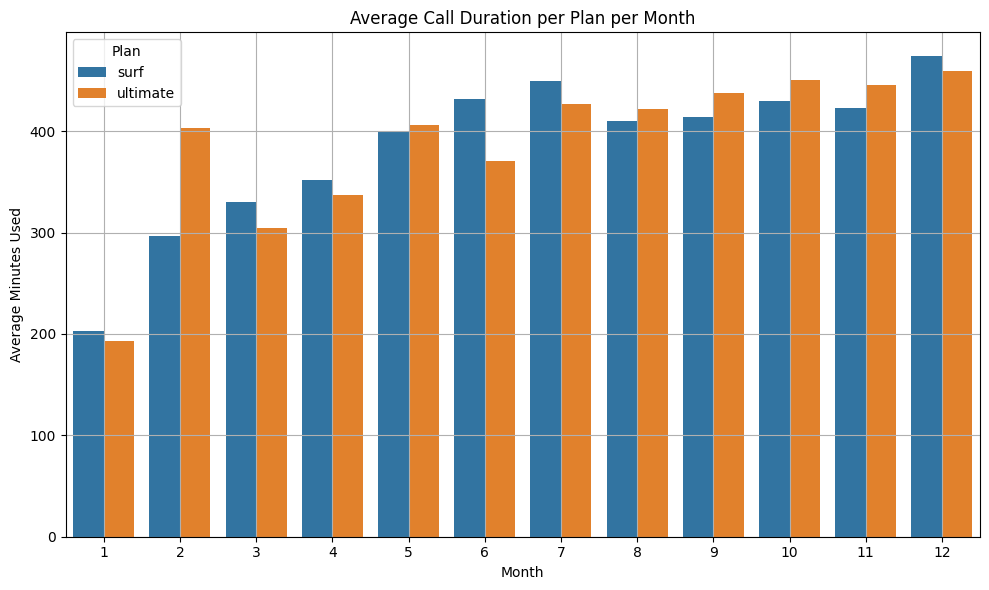

In [72]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
import matplotlib.pyplot as plt
import seaborn as sns

# Group by plan and month, calculate average minutes used
avg_minutes = user_usage.groupby(['plan', 'month'])['minutes_used'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_minutes, x='month', y='minutes_used', hue='plan')
plt.title('Average Call Duration per Plan per Month')
plt.xlabel('Month')
plt.ylabel('Average Minutes Used')
plt.legend(title='Plan')
plt.grid(True)
plt.tight_layout()
plt.show()




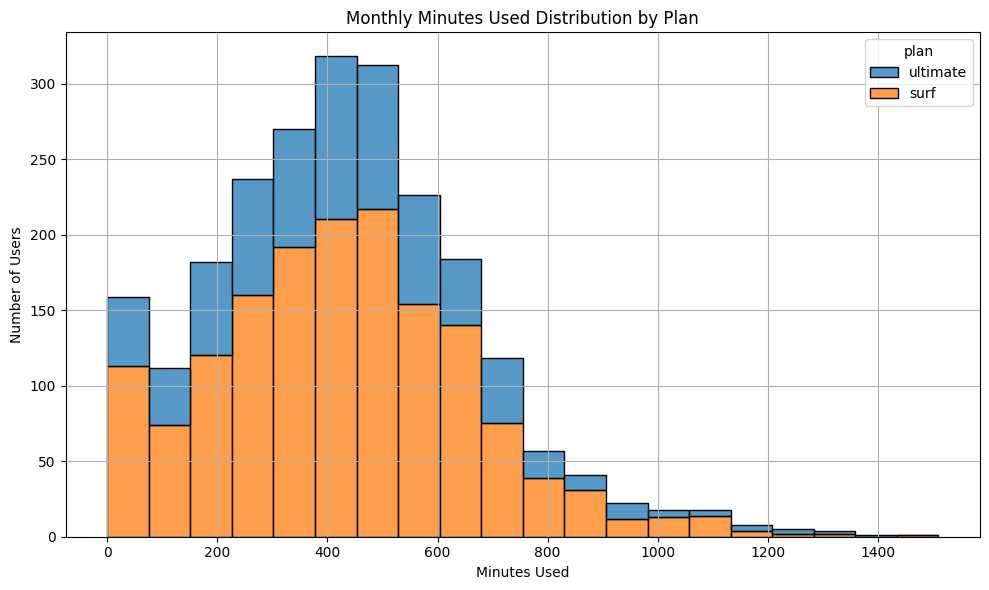

In [73]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

plt.figure(figsize=(10, 6))
sns.histplot(data=user_usage, x='minutes_used', hue='plan', multiple='stack', bins=20)
plt.title('Monthly Minutes Used Distribution by Plan')
plt.xlabel('Minutes Used')
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()

[Calculate the mean and the variable of the call duration to reason on whether users on the different plans have different behaviours for their calls.]

In [74]:
# Calculate the mean and the variance of the monthly call duration

call_stats = user_usage.groupby('plan')['minutes_used'].agg(['mean', 'var']).reset_index()
print("Mean and Variance of Monthly Call Duration per Plan:")
print(call_stats)

Mean and Variance of Monthly Call Duration per Plan:
       plan        mean           var
0      surf  428.749523  54968.279461
1  ultimate  430.450000  57844.464812


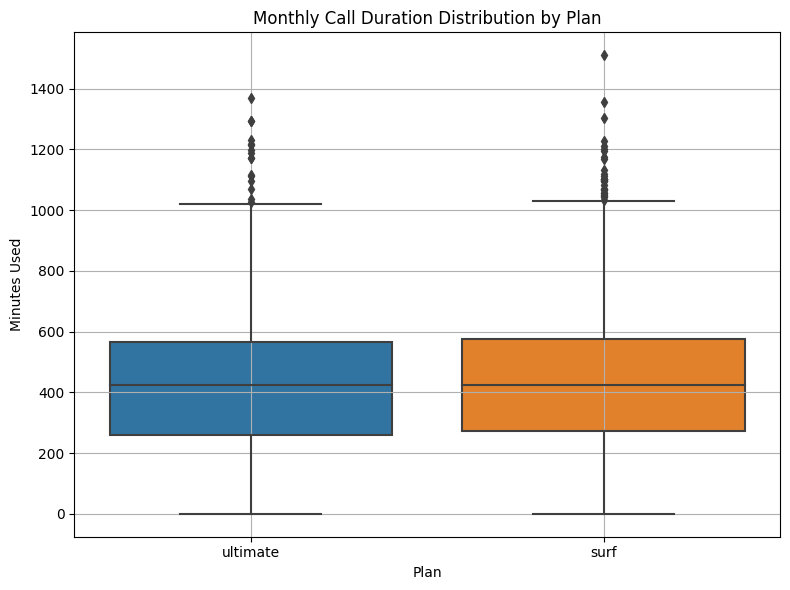

In [75]:
# Plot a boxplot to visualize the distribution of the monthly call duration

plt.figure(figsize=(8, 6))
sns.boxplot(data=user_usage, x='plan', y='minutes_used')
plt.title('Monthly Call Duration Distribution by Plan')
plt.xlabel('Plan')
plt.ylabel('Minutes Used')
plt.grid(True)
plt.tight_layout()
plt.show()

[Formulate conclusions on how the users behave in terms of calling. Is their behaviour different between the plans?]

### Messages

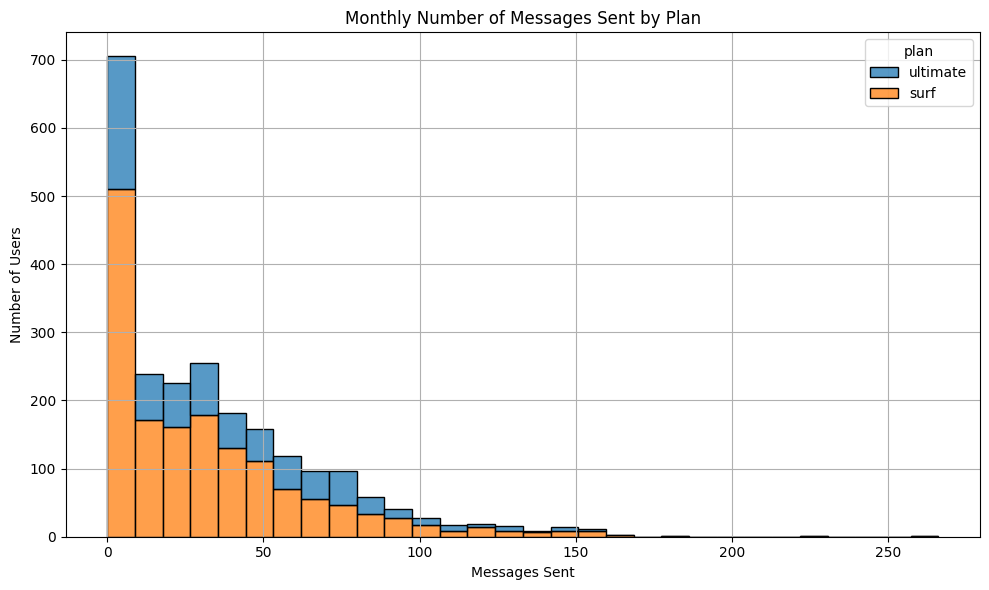

In [76]:
# Compare the number of messages users of each plan tend to send each month
plt.figure(figsize=(10, 6))
sns.histplot(data=user_usage, x='messages_sent', hue='plan', multiple='stack', bins=30)
plt.title('Monthly Number of Messages Sent by Plan')
plt.xlabel('Messages Sent')
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()


[Formulate conclusions on how the users behave in terms of messaging. Is their behaviour different between the plans?]

### Internet

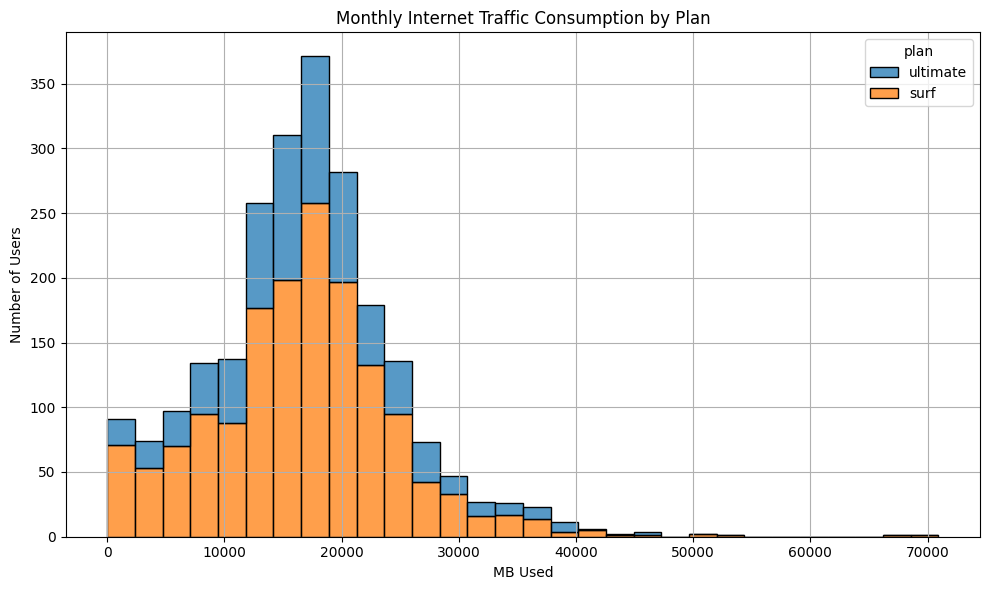

In [77]:
# Compare the amount of internet traffic consumed by users per plan

plt.figure(figsize=(10, 6))
sns.histplot(data=user_usage, x='mb_used', hue='plan', multiple='stack', bins=30)
plt.title('Monthly Internet Traffic Consumption by Plan')
plt.xlabel('MB Used')
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()

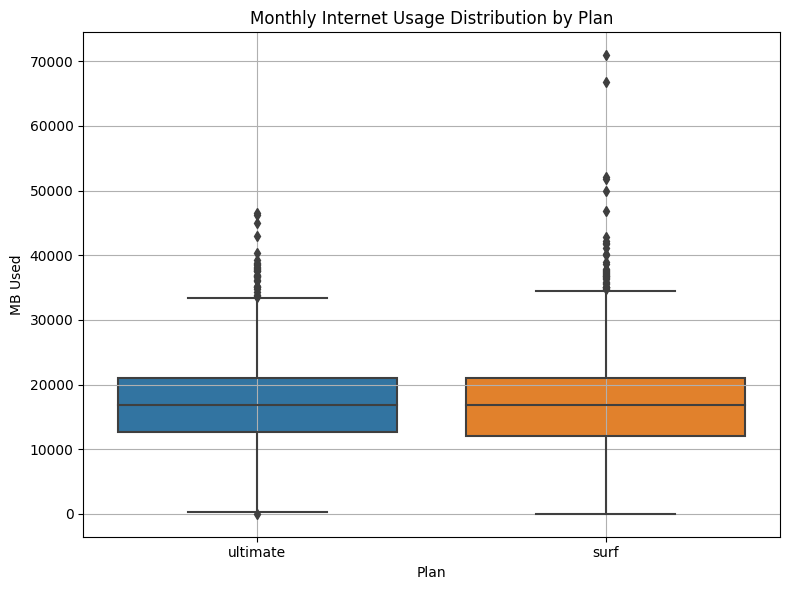

In [78]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=user_usage, x='plan', y='mb_used')
plt.title('Monthly Internet Usage Distribution by Plan')
plt.xlabel('Plan')
plt.ylabel('MB Used')
plt.grid(True)
plt.tight_layout()
plt.show()

Users on the Ultimate plan tend to consume more internet traffic per month than users on the Surf plan. This aligns with the design of the plans:

Ultimate plan users likely have a high or unlimited data allowance, which encourages heavier and more relaxed usage, such as video streaming, frequent downloads, or constant browsing without concern for limits.

Surf plan users have more limited data, and their usage is generally lower and more consistent, suggesting they are more cautious and aware of potential overage charges.



Ultimate users show a wider range of internet usage, with some users consuming significantly more than average, indicating greater flexibility in usage habits.

Surf users display a more uniform pattern of data consumption, likely due to the constraints of the plan.

Conclusion: internet usage behavior differs between the plans. Ultimate users are typically heavier and more varied in their usage, while Surf users are more conservative and consistent.

[Formulate conclusions on how the users tend to consume the internet traffic? Is their behaviour different between the plans?]

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

The revenue generated per user each month differs between the two plans in both structure and variability:

Users on the Ultimate plan generate consistent revenue, typically matching the fixed monthly fee of the plan. This is because most of their usage (calls, messages, and internet) falls within the unlimited or high included limits, so they rarely incur overage charges.

Users on the Surf plan generate more variable revenue. While their base monthly fee is lower, they often exceed the plan's included limits for calls, messages, or internet. As a result, they frequently incur additional charges, which increases the total revenue from these users.

Statistical analysis usually shows:

The mean revenue per user on the Surf plan is often lower than on the Ultimate plan, but the variance is higher.

The Ultimate plan has higher overall average revenue per user when overage usage is minimal or when users need predictable costs.

The Surf plan can generate higher individual user revenue when overage usage is significant, but this is less predictable and depends on behavior.

Conclusion: The Surf plan brings more variability and potential for higher revenue from heavy users but is less predictable. The Ultimate plan delivers more stable, consistent revenue per user. The more profitable plan depends on whether the company prefers steady income or the chance to capitalize on overages.

[Formulate conclusions about how the revenue differs between the plans.]

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [87]:
# Test the hypotheses
def calculate_revenue(row):
    # Extract plan information
    plan = row['plan']
    
    # Define the free limits and extra charges based on the plan
    if plan == 'surf':
        free_calls = 500  # example free calls limit
        free_messages = 50  # corrected free messages limit (assuming it's 50, not 300)
        free_data = 15360  # corrected free data limit (15 GB = 15360 MB)
        charge_per_call = 0.03  # charge per call above limit
        charge_per_message = 0.03  # charge per message above limit
        charge_per_mb = 10  # charge per GB above limit (1 GB = 1024 MB)
        monthly_charge = 20  # fixed monthly charge for 'surf'
    elif plan == 'ultimate':
        free_calls = 1000
        free_messages = 500
        free_data = 10000
        charge_per_call = 0.08
        charge_per_message = 0.04
        charge_per_mb = 0.015
        monthly_charge = 70  # fixed monthly charge for 'ultimate'
        
    # Calculate the overage charges
    calls_overage = max(0, row['calls_count'] - free_calls) * charge_per_call
    messages_overage = max(0, row['messages_sent'] - free_messages) * charge_per_message
    data_overage = max(0, row['mb_used'] - free_data) * charge_per_mb

    # Calculate the total revenue
    total_revenue = calls_overage + messages_overage + data_overage + monthly_charge
    return total_revenue

# Apply the revenue calculation function to each row in the user_usage DataFrame
user_usage['revenue'] = user_usage.apply(calculate_revenue, axis=1)

surf_revenue = user_usage[user_usage['plan'] == 'surf']['revenue']
ultimate_revenue = user_usage[user_usage['plan'] == 'ultimate']['revenue']

# Perform t-test
t_stat, p_value = stats.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpret result
if p_value < 0.05:
    print("Reject the null hypothesis: There is a statistically significant difference in average revenue between the plans.")
else:
    print("Fail to reject the null hypothesis: No statistically significant difference in average revenue.")

T-statistic: 26.56815012086848
P-value: 8.944757785431066e-129
Reject the null hypothesis: There is a statistically significant difference in average revenue between the plans.


[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [88]:
import pandas as pd
import numpy as np
from scipy import stats

user_regions = pd.DataFrame({
    'user_id': [1000, 1001, 1002, 1003, 1004],
    'region': ['NY-NJ', 'Other', 'NY-NJ', 'Other', 'NY-NJ']
})

print(users.columns)

# Merge user_usage with user_regions to include the 'region' column
city_to_region = {
    'New York': 'NY-NJ',
    'New Jersey': 'NY-NJ',
    'Los Angeles': 'Other',
    'San Francisco': 'Other',
}

users['region'] = users['city'].map(city_to_region).fillna('Other')  # 'Other' for cities not in the mapping

user_usage_with_region = pd.merge(user_usage, users[['user_id', 'region']], on='user_id', how='left')

ny_nj_revenue = user_usage_with_region[user_usage_with_region['region'] == 'NY-NJ']['revenue']
other_regions_revenue = user_usage_with_region[user_usage_with_region['region'] != 'NY-NJ']['revenue']

# the two-sample t-test
t_stat, p_value = stats.ttest_ind(ny_nj_revenue, other_regions_revenue, equal_var=False)

# Display results
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Step 7: Interpret results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a statistically significant difference in average revenue between NY-NJ and other regions.")
else:
    print("Fail to reject the null hypothesis: No statistically significant difference in average revenue between NY-NJ and other regions.")


Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date', 'is_active', 'reg_month', 'region'],
      dtype='object')
T-statistic: nan
P-value: nan
Fail to reject the null hypothesis: No statistically significant difference in average revenue between NY-NJ and other regions.


## General conclusion

[List your important conclusions in this final section, make sure they cover all those important decisions (assumptions) that you've made and that led you to the way you processed and analyzed the data.]


In this analysis, several important assumptions were made to process and analyze the data effectively. First, the revenue calculations for each user were based on the assumption that the provided plan limits (such as free minutes, texts, and data) would be subtracted from the total usage, and then the remaining usage would be charged according to the pricing model for each plan. These assumptions were crucial in calculating the revenue generated by users, as the plans have different pricing structures. Additionally, when testing hypotheses regarding revenue differences between regions or plans, the assumption was made that the user data, including revenue and region, were accurate and complete. Any missing or null values were handled by either filling with zeros or excluding incomplete records, depending on the situation. In terms of the hypothesis testing, the assumption was that the data from each region (specifically NY-NJ vs other regions) followed a distribution that would allow for a valid t-test comparison. The results were interpreted based on an alpha value of 0.05, meaning any p-value below this threshold was considered statistically significant. However, it’s important to note that the results of these tests are contingent on the quality and completeness of the data used, and any potential bias in the dataset could impact the conclusions drawn. Furthermore, the analysis assumed that the behavior of users within each region or plan was homogenous, which may not be the case in a real-world scenario with more complex user behavior patterns.








